In [1]:
!pip install shap

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
      --------------------------------------- 10.2/456.1 kB ? eta -:--:--
      --------------------------------------- 10.2/456.1 kB ? eta -:--:--
      --------------------------------------- 10.2/456.1 kB ? eta -:--:--
     --- --------------------------------- 41.0/456.1 kB 178.6 kB/s eta 0:00:03
     --- --------------------------------- 41.0/456.1 kB 178.6 kB/s eta 0:00:03
     --- --------------------------------- 41.0/456.1 kB 178.6 kB/s eta 0:00:03
     --- --------------------------------- 41.0/456.1 kB 178.6 kB/s eta 0:00:03
     ----------- ------------------------ 143.4/456.1 kB 387.0 kB/s eta 0:00:01
     ----------- ------------------------ 143.4/456.1 kB 387.0 kB/s eta 0:00:01
     ----------- ------------------------ 143.4/456.1 kB 387.0 kB/s eta 0:00:01
     -------------------------- --------- 337.9/456.1 kB 635.0 kB/s eta 0:00:01
     

In [3]:
print(model)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
print(dataset.column_names)


['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'pixel_values']


In [6]:
print(model.config.id2label)  

{0: 'benign_keratosis-like_lesions', 1: 'basal_cell_carcinoma', 2: 'actinic_keratoses', 3: 'vascular_lesions', 4: 'melanocytic_Nevi', 5: 'melanoma', 6: 'dermatofibroma'}


Using the latest cached version of the dataset since marmal88/skin_cancer couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\18903\.cache\huggingface\datasets\marmal88___skin_cancer\default\0.0.0\bdd59e10860746202dfdc452e0ac3a9eaa25268d (last modified on Thu Mar 13 22:05:26 2025).


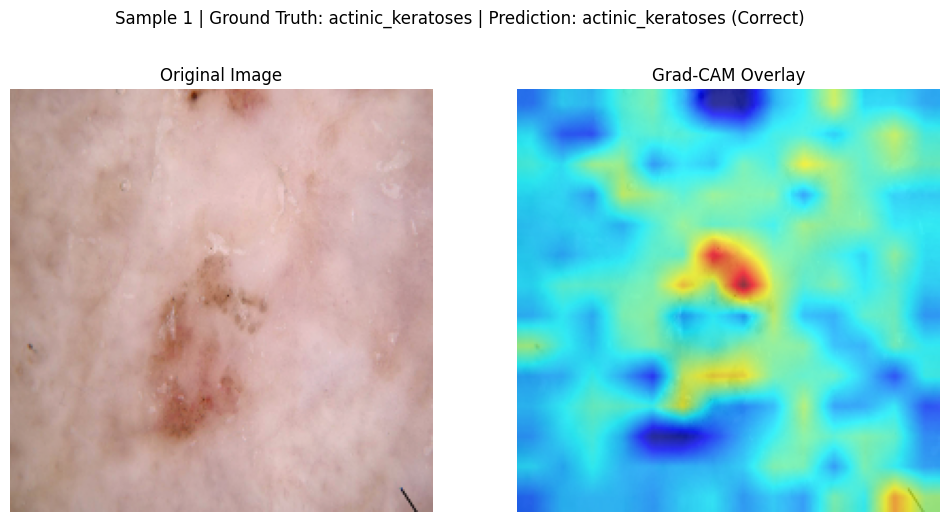

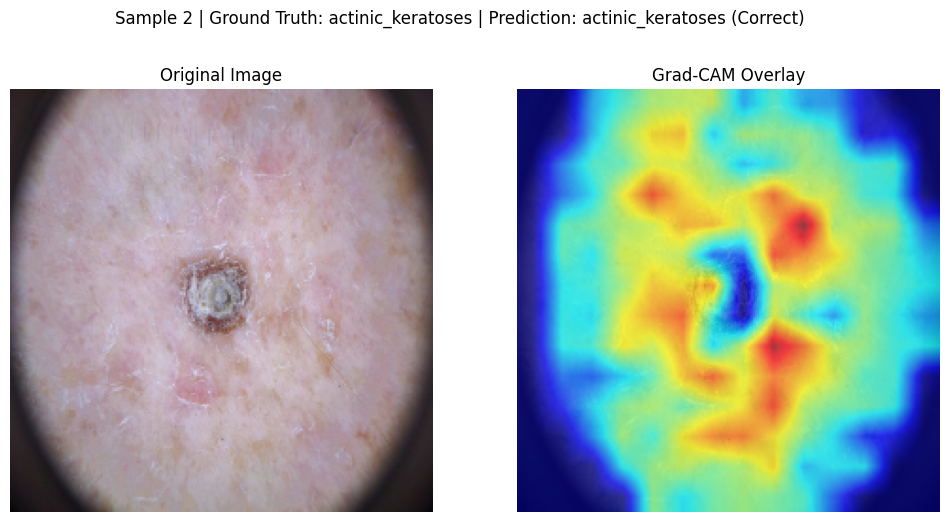

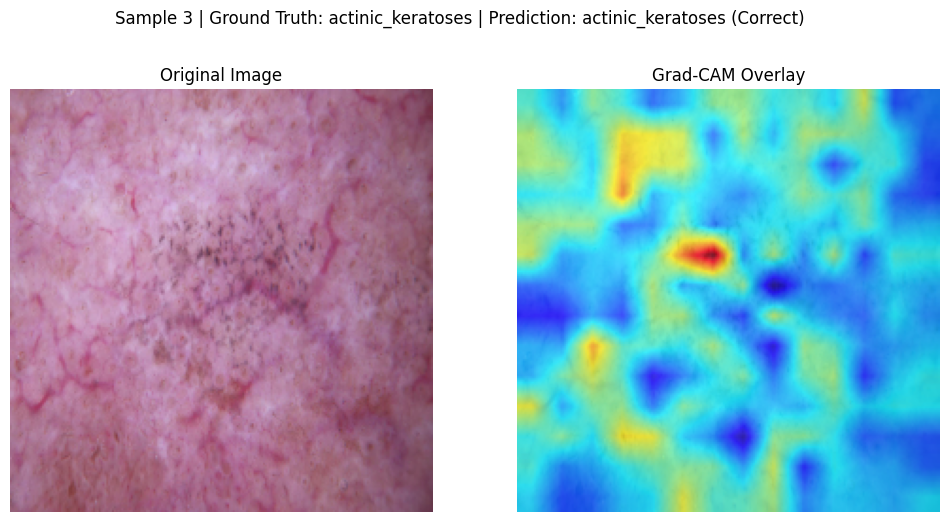

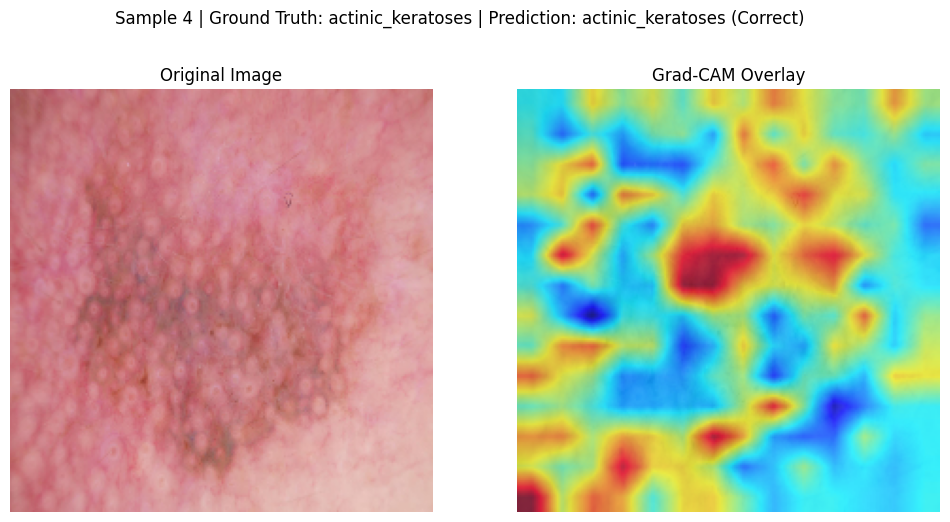

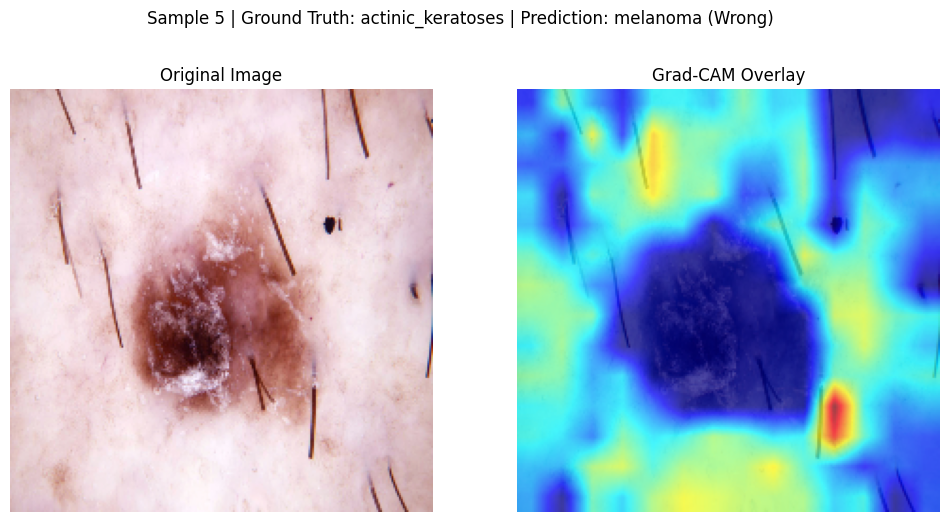

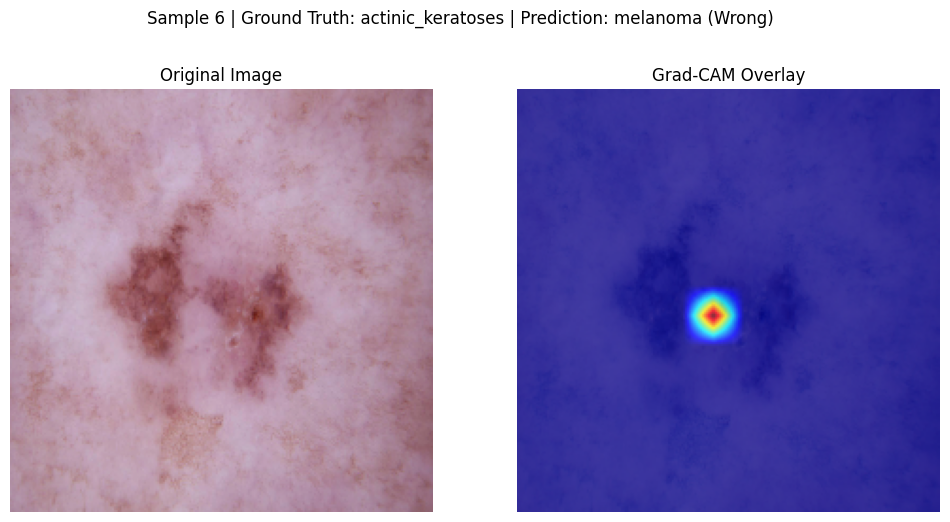

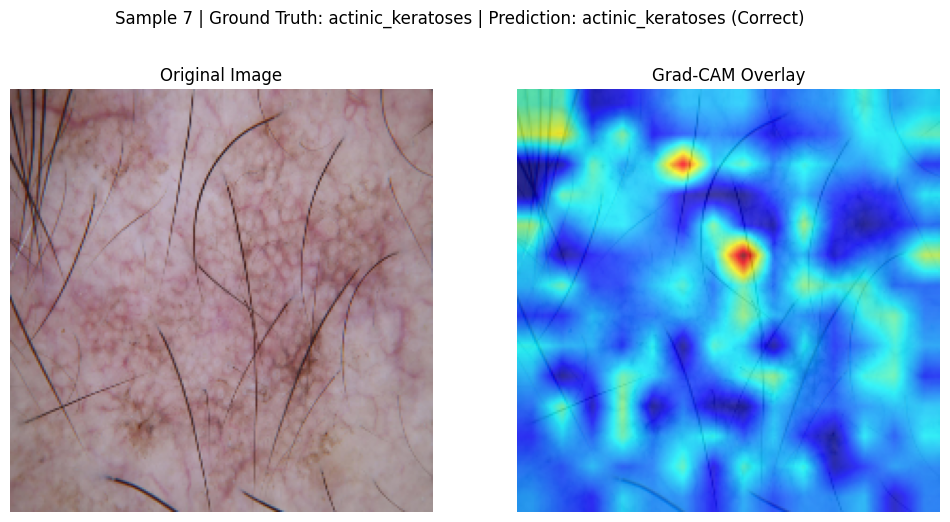

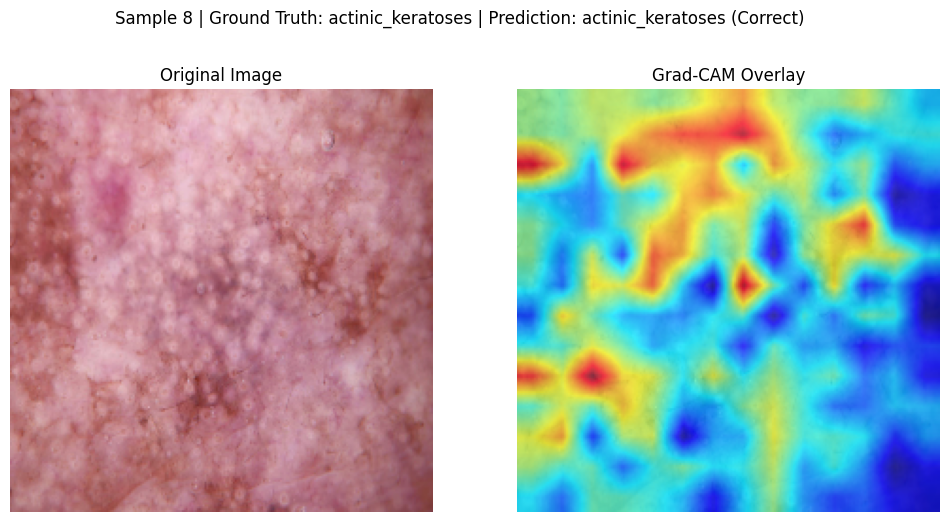

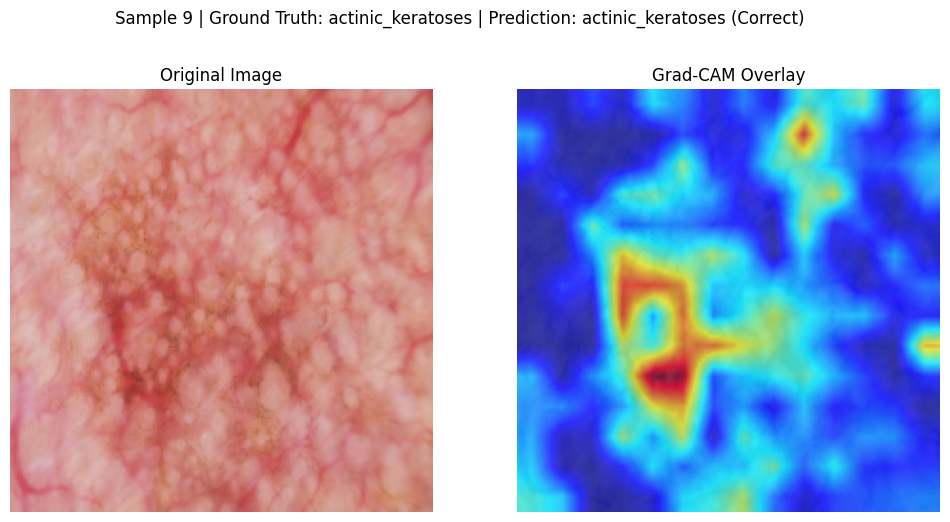

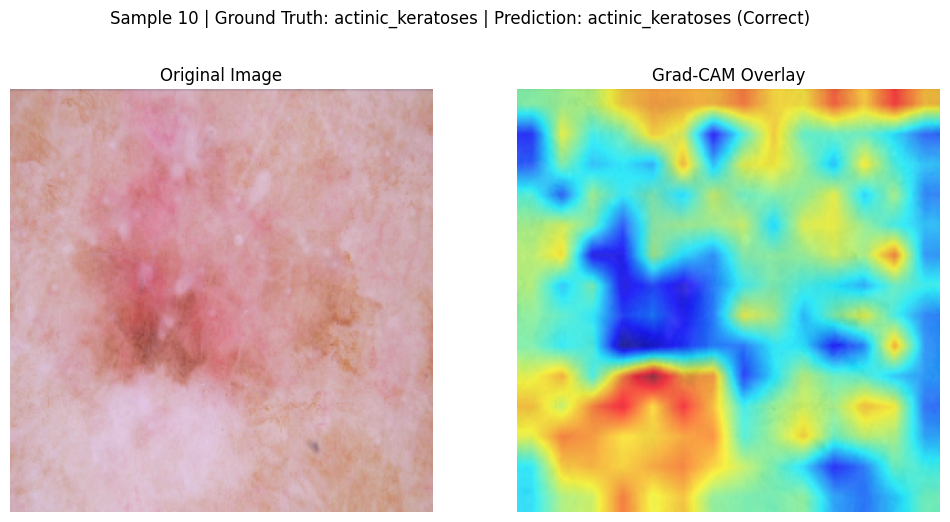

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from datasets import load_dataset

# Define class mapping dictionary (order as used during training)
label_mapping = {
    0: 'benign_keratosis-like_lesions',
    1: 'basal_cell_carcinoma',
    2: 'actinic_keratoses',
    3: 'vascular_lesions',
    4: 'melanocytic_Nevi',
    5: 'melanoma',
    6: 'dermatofibroma'
}

# -------------------------
# Modified Grad-CAM class (for 4D convolution outputs)
# -------------------------
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None  # Store forward activations
        self.gradients = None    # Store backward gradients

        # Register hooks to capture target layer's activations and gradients
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        # For convolution layers, output shape is [B, C, H, W]
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output[0] shape is [B, C, H, W]
        self.gradients = grad_output[0]

    def __call__(self, inputs):
        self.model.zero_grad()
        output = self.model(inputs)
        # Select the class with the highest logit
        index = output.argmax()
        target = output[0, index]
        target.backward()

        # Get gradients and activations from target layer
        gradients = self.gradients   # shape: [B, C, H, W]
        activations = self.activations   # shape: [B, C, H, W]

        # Global average pool over spatial dimensions to get channel weights
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # shape: [B, C, 1, 1]
        # Compute weighted sum over channels to obtain CAM
        cam = (activations * weights).sum(dim=1)  # shape: [B, H, W]
        cam = torch.relu(cam)
        # Take CAM of the first image and normalize to [0,1]
        cam = cam[0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        # Resize CAM to match input image size (224x224)
        cam = cv2.resize(cam, (224, 224))
        return cam

# -------------------------
# Helper function to generate heatmap overlay
# -------------------------
def gen_cam(image, mask):
    # Retain positive values and amplify mask differences
    mask = np.maximum(mask, 0)
    mask = mask * 3.0
    # Normalize mask to [0,1]
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    # Apply JET colormap: low values as blue, high values as warm colors (yellow, red)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    # Fuse heatmap with original image: 70% heatmap, 30% original image
    cam = 0.7 * heatmap + 0.3 * image
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# -------------------------
# Evaluation code
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model and feature extractor
model_name = "Anwarkh1/Skin_Cancer-Image_Classification"
original_model = ViTForImageClassification.from_pretrained(model_name).to(device)
original_model.config.return_dict = False
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Model wrapper: return only logits to ensure gradients are preserved
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, inputs):
        outputs = self.model(inputs)
        return outputs[0] if isinstance(outputs, tuple) else outputs

wrapped_model = ModelWrapper(original_model).to(device)

# Load dataset (skin_cancer test set)
dataset = load_dataset("marmal88/skin_cancer", split="test")

# Modify target layer: use the projection (convolution) layer from patch embedding.
# This layer outputs shape [B, C, 14, 14] and preserves spatial structure.
target_layer = original_model.vit.embeddings.patch_embeddings.projection

# Initialize Grad-CAM
grad_cam = GradCam(wrapped_model, target_layer)
wrapped_model.eval()

# Evaluate first 10 images: display original image and Grad-CAM overlay with model predictions
for i in range(10):
    sample = dataset[i]
    # Convert image to numpy array (if PIL.Image, convert using np.array)
    if hasattr(sample["image"], "convert"):
        original_img = np.array(sample["image"])
    else:
        original_img = sample["image"]
    
    # Resize image to 224x224 and normalize to [0,1]
    resized_img = cv2.resize(original_img, (224, 224))
    norm_img = np.float32(resized_img) / 255.0
    
    # Preprocess image using feature extractor
    inputs = feature_extractor(images=resized_img, return_tensors="pt")
    inputs = inputs["pixel_values"].to(device)
    
    # Perform forward pass through model to obtain prediction
    with torch.no_grad():
        outputs = wrapped_model(inputs)
    predicted_index = outputs.argmax(dim=1).item()
    predicted_label = label_mapping[predicted_index]
    gt_label = sample["dx"]  # Assume ground truth label is stored in "dx" field
    correctness = "Correct" if predicted_label == gt_label else "Wrong"
    
    # Compute Grad-CAM mask (single-channel heatmap)
    mask = grad_cam(inputs)
    
    # Generate final overlay heatmap
    overlay = gen_cam(norm_img, mask)
    
    # Display original image and Grad-CAM result side-by-side with ground truth and prediction in title
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(norm_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Grad-CAM Overlay")
    axs[1].axis("off")
    plt.suptitle(f"Sample {i+1} | Ground Truth: {gt_label} | Prediction: {predicted_label} ({correctness})")
    plt.show()
